In [1]:
import random
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
manual_seed = 11037580

random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results
np.random.seed(manual_seed)

training_data_dir = './data/train'

workers = 4
batch_size = 256
z_size = 64
num_gen_features = 128
num_dis_features = 128

epochs = 87
lr = 2e-4
beta1 = 0.5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
dataset = torchvision.datasets.ImageFolder(root = training_data_dir,
                                               transform=torchvision.transforms.Compose([
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                               torchvision.transforms.Resize(64)
                                           ]))

dataset_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [3]:
# Have to initialise weights for the DCGAN as shown in https://arxiv.org/pdf/1511.06434

def init_weights(x):
    if x.__class__.__name__.find('Conv') != -1:
        torch.nn.init.normal_(x.weight.data, 0.0, 0.02)
    elif x.__class__.__name__.find('BatchNorm') != -1:
        torch.nn.init.normal_(x.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(x.bias.data, 0)

In [4]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(z_size, num_gen_features * 8, 4, stride=1, padding=0, bias=False),
            torch.nn.BatchNorm2d(num_gen_features * 8),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(num_gen_features * 8, num_gen_features * 4, 4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(num_gen_features * 4),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(num_gen_features * 4, num_gen_features * 2, 4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(num_gen_features * 2),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(num_gen_features * 2, num_gen_features, 4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(num_gen_features),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(num_gen_features, 3, 4, stride=2, padding=1, bias=False),
            torch.nn.Tanh(),
        )
    def forward(self, input):
        return self.net(input)

net_gen = Generator().to(device)
net_gen.apply(init_weights)
print(net_gen)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(64, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  

In [5]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = torch.nn.Sequential(
            # Aggressive early downsampling from 512x512 to 128x128
            torch.nn.Conv2d(3, num_dis_features, kernel_size=4, stride=4, padding=1, bias=False),  # 512 -> 128
            torch.nn.LeakyReLU(0.4, inplace=True),
            
            # Intermediate layers downsampling further
            torch.nn.Conv2d(num_dis_features, num_dis_features * 2, kernel_size=4, stride=2, padding=1, bias=False),  # 128 -> 64
            torch.nn.BatchNorm2d(num_dis_features * 2),
            torch.nn.LeakyReLU(0.4, inplace=True),
            
            torch.nn.Conv2d(num_dis_features * 2, num_dis_features * 4, kernel_size=4, stride=2, padding=1, bias=False),  # 64 -> 32
            torch.nn.BatchNorm2d(num_dis_features * 4),
            torch.nn.LeakyReLU(0.4, inplace=True),
            
            torch.nn.Conv2d(num_dis_features * 4, num_dis_features * 8, kernel_size=4, stride=2, padding=1, bias=False),  # 32 -> 16
            torch.nn.BatchNorm2d(num_dis_features * 8),
            torch.nn.LeakyReLU(0.4, inplace=True),
            
            # Optional additional layer for further downsampling (16 -> 8)
            torch.nn.Conv2d(num_dis_features * 8, num_dis_features * 16, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(num_dis_features * 16),
            torch.nn.LeakyReLU(0.4, inplace=True),
            
            # Adaptive pooling to collapse spatial dimensions to 1x1 regardless of the input size
            torch.nn.AdaptiveAvgPool2d((1, 1)),
            
            # Final convolution to produce a single scalar output per image
            torch.nn.Conv2d(num_dis_features * 16, 1, kernel_size=1, stride=1, padding=0, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        return self.net(input)

net_dis = Discriminator().to(device)
net_dis.apply(init_weights)
print(net_dis)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.4, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.4, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.4, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.4, inplace=True)
    (11): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(2048, eps=1

In [6]:
criterion = torch.nn.BCELoss()
fixed_noise = torch.randn(batch_size, z_size, 1, 1, device=device)
real_label = 1
fake_label = 0

optimiser_gen = torch.optim.Adam(net_gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimiser_dis = torch.optim.Adam(net_dis.parameters(), lr=lr, betas=(beta1, 0.999))

In [7]:
loss_gen_list = []
loss_dis_list = []
images = []

for epoch in range(epochs):
    for i, data in enumerate(dataset_loader, 0):

        #Discriminator network (REAL DATA)
        net_dis.zero_grad()
        
        real_im = data[0].to(device)
        label = torch.full((real_im.size(0),), real_label, dtype=torch.float, device=device)

        output = net_dis(real_im)
        output = output.view(-1)
        loss_dis_real = criterion(output, label)
        loss_dis_real.backward()
        D_x = output.mean().item()

        #Discriminator network (FAKE DATA (GEN MODEL))
        random_vector = torch.randn(real_im.size(0), z_size, 1, 1, device=device)
        fake_im = net_gen(random_vector)
        label = torch.full((fake_im.size(0),), fake_label, dtype=torch.float, device=device)

        output = net_dis(fake_im.detach()).view(-1)
        loss_dis_fake = criterion(output, label)
        loss_dis_fake.backward()
        D_G_z1 = output.mean().item()
        loss_dis = loss_dis_real + loss_dis_fake
        optimiser_dis.step()
        

        #Generator network update
        net_gen.zero_grad()
        label.fill_(real_label) #The generator wants this to be the label
                                # so for the loss calculation on the discriminator network
                                # the real label (haha you got tricked) should be used
        output = net_dis(fake_im).view(-1)
        loss_gen = criterion(output, label)
        loss_gen.backward()
        D_G_z2 = output.mean().item()
        optimiser_gen.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataset_loader),
                     loss_dis.item(), loss_gen.item(), D_x, D_G_z1, D_G_z2))

        loss_gen_list.append(loss_gen.item())
        loss_dis_list.append(loss_dis.item())


    output = net_gen(torch.randn(1, z_size, 1, 1, device=device))[0]
    im = torch.transpose(torch.transpose(output.detach().cpu(), 0, 2), 0, 1).numpy().copy()
    images.append(im)
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': net_gen.state_dict(),
        'optimizer_state_dict': optimiser_gen.state_dict(),
        'loss': loss_gen.item()
    }, 'Generator.pt_check')

    torch.save({
        'epoch': epoch,
        'model_state_dict': net_dis.state_dict(),
        'optimizer_state_dict': optimiser_dis.state_dict(),
        'loss': loss_dis.item()
    }, 'Discriminator.pt_check')

[0/87][0/61]	Loss_D: 1.5445	Loss_G: 0.8805	D(x): 0.6085	D(G(z)): 0.6072 / 0.5259
[1/87][0/61]	Loss_D: 1.2397	Loss_G: 0.9556	D(x): 0.5717	D(G(z)): 0.4278 / 0.4104
[2/87][0/61]	Loss_D: 0.8661	Loss_G: 1.4898	D(x): 0.6944	D(G(z)): 0.3106 / 0.3190
[3/87][0/61]	Loss_D: 1.6751	Loss_G: 1.8370	D(x): 0.6522	D(G(z)): 0.3501 / 0.3256
[4/87][0/61]	Loss_D: 1.0953	Loss_G: 2.1441	D(x): 0.5830	D(G(z)): 0.2447 / 0.2430
[5/87][0/61]	Loss_D: 2.1613	Loss_G: 2.8311	D(x): 0.5298	D(G(z)): 0.1928 / 0.2958
[6/87][0/61]	Loss_D: 0.3830	Loss_G: 2.4746	D(x): 0.8487	D(G(z)): 0.0997 / 0.0961
[7/87][0/61]	Loss_D: 0.3659	Loss_G: 2.6767	D(x): 0.8436	D(G(z)): 0.0828 / 0.0987
[8/87][0/61]	Loss_D: 5.8656	Loss_G: 4.3453	D(x): 0.5608	D(G(z)): 0.3877 / 0.3833
[9/87][0/61]	Loss_D: 1.4008	Loss_G: 1.8478	D(x): 0.6953	D(G(z)): 0.1891 / 0.2406
[10/87][0/61]	Loss_D: 0.8769	Loss_G: 2.9543	D(x): 0.6881	D(G(z)): 0.1833 / 0.1229
[11/87][0/61]	Loss_D: 2.2060	Loss_G: 2.3074	D(x): 0.4929	D(G(z)): 0.1713 / 0.1634
[12/87][0/61]	Loss_D: 2.24

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98668385..0.99019176].


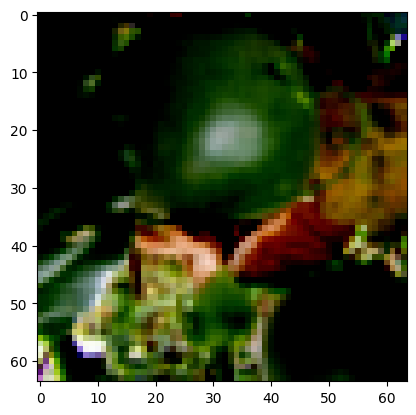

In [8]:
for data in (dataset_loader):
    im  = torch.transpose(torch.transpose(data[0][0].detach().cpu(), 0, 2), 0, 1).numpy()
    plt.imshow(im)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91122174..0.895742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9696795..0.87027895].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9509408..0.81444657].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96328783..0.9076609].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9683198..0.8256736].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98191255..0.92497385].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9

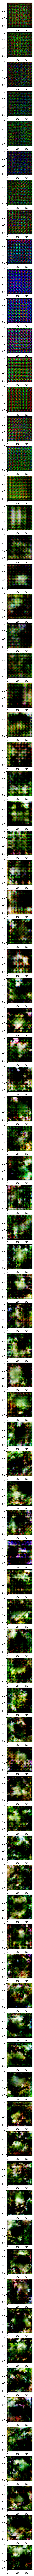

In [15]:
fig, axs = plt.subplots(nrows=len(images), figsize=(4, 2*len(images)))
for i, ax in enumerate(axs):
    ax.imshow(images[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9575408..0.9784735].


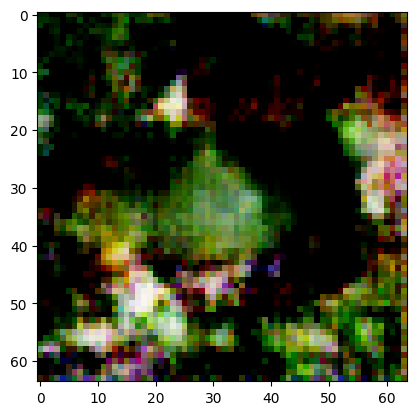

In [14]:
 plt.imshow(images[-3])